<hr style="border-width: 2px; border-color: #75dfc1;">

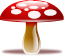

<table style='border: 3px solid black; width: 100%;'>
    <tr>
        <th style='width: 5%;'>&nbsp;</th>        
        <th><center><h1 style='font-size: 38px;'>[ MUSHROOM Project ]</h1></center></th>
        <th style='width: 5%'>&nbsp;</th>
    </tr>
    <tr>
        <td>&nbsp;</td>
        <td>Project type: <span style='color: blue;'><strong>Image Classification</strong></span></td>        
        <td>&nbsp;</td>
    </tr>
    <tr>
        <td>&nbsp;</td>
        <td>Autors: </span><strong><span style='color: blue;'>Olivier CONSTANTIN</span> / <span style='color: blue;'>David CHARLES-ELIE-NELSON</span></strong></td>
        <td>&nbsp;</td>
    </tr>
</table>

<hr style="border-width: 2px; border-color: #75dfc1;">

## Notebook: ---( DATA COLLECT - part 1: Extracting data from website )---</h1></td>

[ Test Notebook ]

<hr style="border-width: 2px; border-color: #75dfc1;">

# Introduction

## Context

For the project, we needed to get many mushroom images.  
All these images will constitue our dataset.  
We need a dataset to train models to learn classify mushrooms.

The problem is so the following: **how to retrieve all those images ?**

Fortunately we can find a lot of websites on internet dealing with mushrooms.  
For our needs we decided to use the website [MushroomObserver.org](https://mushroomobserver.org) as datasource.  
This particular website has the following advantages:
   * an **API**
     The main advantages of this website is that it has an API (Application Programming Interface) that allows users to interact with the content of the website. For our needs we used this API to download mushrooms images.


   * the associate **class**  
     Our needs are not limited to images. As the purpose of this project is to build a model that will be able to classify mushrooms we have to associate to each mushroom image the corresponding class. In our case, the class will consist of a level of the mushroom taxonomy. We started with the "gender" taxonomy level, but the problem is the same with another taxonomy level (the only imperative is to associate the corresponding class to each mushroom image that constitute the dataset).



## Purpose of this notebook

This notebook will present how the mushroomObserver website API was used in the context of the project to build the needed dataset.

In the context of the project we tried to get enough images to give us a chance to build performant enough classification models. This led us to download many mushroom images.  
As you can imagine, this produce an important impact on the website (from a performance point of view).

So has the objective of this notebook is just to present the way we used to build our dataset, we won't try here to download a lot of things from mushroomObserver website, but just a few data to demonstrate the procedure.  


## Data description

The mushroomObserver website is based (partially) on the following data:  
   * observation
   * image
   * names

Our dataset will finally be composed of images + names (classes), but to retrieve these data we have also get the observations.  
So in this notebook we will see how to retrieve:
   * observation whose ID = 463289
     This ID was found directly from the website (on which you can launch a search on observations. Then an ID was choosen for the need of this notebook.) 
   * all image associated with the given observation ID.
     The step here will consist to get all image URLs associated with the observation ID.
   * all names associated with images.

<u>Remarks</u>:     
It is possible that the observation ID that it is used in this notebook may be deleted on the website. So when this notebook will be run, no observation will be retrieve from the website. If this case happen, then you can go the website, search for observations and get a new ID. Then you will just have to replace the value of OBSERVATION_ID parameter in this notebook.



# Initialization

## Import Standard Libraries

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Import Standard Libraries
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

import os
import sys

import json

import unittest

## Settings

In [ ]:
OBSERVATION_ID = 463289
    # The observation ID used to retrieve associated mushroom images.
    # This value can be changed if needed.

### Path Settings

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Path Settings
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

class PathSettings():
    
    def __init__(self,
            gdriveMountPoint    = None 
        ,   projectRootPath     = None
        ,   srcPath             = None
        ,   datasourcePath      = None
        ,   datasourceName      = None
        ,   modelOutputRootPath = None
        ,   imageRootDir        = None
    ):
        self.value = dict(
                GOOGLE_DRIVE_MOUNT_POINT = gdriveMountPoint
            ,   PROJECT_ROOT_PATH        = projectRootPath
            ,   SRC_PATH                 = srcPath
            ,   DATASOURCE_PATH          = datasourcePath
            ,   DATASOURCE_NAME          = datasourceName
            ,   MODEL_OUTPUT_ROOT_PATH   = modelOutputRootPath
            ,   IMAGE_ROOT_DIR           = imageRootDir
        )
    
    
    def getSettings(self):
        return self.value

    
    def get(self, pathname):
        if pathname:
            return self.value.get(pathname.upper())
        else:
            return None
        
        
    def add(self, pathname, value, overwrite = False):
        if overwrite is None:
            overwrite = False
        if pathname not in self.getPathnames() or overwrite:
            self.value[pathname.upper()] = value
        else:
            raise KeyError(f'Unable to add the path: pathname "{pathname}" already exists and <overwrite> parameter is set to False.')
            
            
    def getPathnames(self):
        if self.value:
            return self.value.keys()
        else:
            return None
    


PATH_SETTINGS = PathSettings(
        gdriveMountPoint    = '/content/drive'
    ,   projectRootPath     = '/content/drive/MyDrive/Mushroom_project'
    ,   srcPath             = '/content/drive/MyDrive/Mushroom_project/repo_git/src'
)
    
# Specific initialization for GOOGLE COLAB platform
#
# Import Libraries
from google.colab import drive
# For Google Colab only !
gdriveMountPath = PATH_SETTINGS.get('GOOGLE_DRIVE_MOUNT_POINT')
if gdriveMountPath:
    # Mount the google drive if not already done
    if not os.path.isdir(gdriveMountPath):
        drive.mount(gdriveMountPath)
        print(f'Google drive mounted in: "{gdriveMountPath}""')
else:
    raise Exception('Failed to retrieve the Google Drive mount point path !')

## Initialization for Custom Libraries

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Initialization for Custom Librairies
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Retrieving paths
srcDir = PATH_SETTINGS.get('SRC_PATH')

if srcDir and os.path.isdir(srcDir):
    libDir = os.path.join(srcDir, 'lib')
    if libDir not in sys.path:
        sys.path.append(libDir)
        print(f'INFO: Project directory added to PYTHONPATH: {libDir}')
else:
    raise Error('Invalid value for variable <libDir>')

## Import Custom Libraries

In [ ]:
from data_collect.mushroomObserver.api import api
from data_collect.mushroomObserver.api import taxon as tx
from data_collect.mushroomObserver.api import observation as obs
from data_collect.mushroomObserver.api import image as img

# Declarations

## Class: Observation API Test

In [ ]:
class APITest:
    def __init__(self, moAPIHttp = None):
        if moAPIHttp is None:
            self.moAPIHttp = api.CMO_API_HTTP(httpDelaySec = 0)
        else:
            self.moAPIHttp = moAPIHttp




class ObsAPITest(APITest):

    def __init__(self, moAPIHttp = None):
        super().__init__(moAPIHttp)
        

    def run(self, obsReq):
        '''
        DESCRIPTION
            This test will consist in retrieving OBSERVATIONS from website.
            Only observations corresponding to the "obsReq" request (i.e. filter) will be retrieved.
        ARGUMENTS
            obsReq
                object of type data_collect.mushroomObserver.api.CMO_API_GET_Obs_Request 
                that represent the filter that will be considered while extracting data from the website.
                Only observations corresponding to this filter will be retrieved from the website.
        '''

        print('\n[INFO]: Entering HTTP GET [OBSERVATION] Test...')

        print('\nRetrieving observations from website...')

        # Creating an OBSERVATION Extractor
        obsExtractor = obs.CMO_API_GET_Observation(
                moAPIHttp_GET_obs_req = obsReq
            ,   moAPIHttp             = self.moAPIHttp
        )

        # Looping over all result pages
        recsetObs       = []
        recsetObsNaming = []
        recsetObsImage  = []
        while obsExtractor.get(verbose = True):

            obsResult = obsExtractor.get_result()

            if (obsResult is not None):

                obsData = obs.CMO_API_Obs_Data(obsResult)

                recsetObs       = recsetObs       + obsData.get_recsetObs()
                recsetObsNaming = recsetObsNaming + obsData.get_recsetObsNaming()
                recsetObsImage  = recsetObsImage  + obsData.get_recsetObsImage()

                del obsData

        print('')
        print(f'Number of records: {len(recsetObs)}')

        print('')
        print('Observation record data:')
        for i, record in enumerate(recsetObs):
            print(f'Observation[{i+1}]:\n{record}')

        del recsetObs
        del recsetObsNaming
        del recsetObsImage

        print('[INFO]: Leaving HTTP GET [OBSERVATION] Test...')




class TaxonAPITest(APITest):

    def __init__(self, moAPIHttp = None):
        super().__init__(moAPIHttp)


    def run(self, taxonReq):
        '''
        DESCRIPTION
            This test will consist in retrieving TAXONS from website.
            Only taxons corresponding to the "taxonReq" request (i.e. filter) will be retrieved.
        ARGUMENTS
            taxonReq
                object of type data_collect.mushroomObserver.api.CMO_API_GET_Taxon_Request 
                that represent the filter that will be considered while extracting data from the website.
                Only taxons corresponding to this filter will be retrieved from the website.
        '''

        print('\n[INFO]: Entering HTTP GET [TAXON] Test...')

        print('\nRetrieving taxons from website...')

        # Creating a TAXON Extractor
        taxonExtractor = tx.CMO_API_GET_Taxon(
                moAPIHttp_GET_taxon_req = taxonReq
            ,   moAPIHttp               = self.moAPIHttp
        )

        # Looping over all result pages
        recsetTaxon        = []
        recsetTaxonParent  = []
        recsetTaxonSynonym = []
        while taxonExtractor.get(verbose = True):

            taxonResult = taxonExtractor.get_result()

            if (taxonResult is not None):

                taxonData = tx.CMO_API_Taxon_Data(taxonResult)

                recsetTaxon        = recsetTaxon        + taxonData.get_recsetTaxon()
                recsetTaxonParent  = recsetTaxonParent  + taxonData.get_recsetTaxonParent()
                recsetTaxonSynonym = recsetTaxonSynonym + taxonData.get_recsetTaxonSynonym()

                del taxonData

        print('')
        print(f'Number of records: {len(recsetTaxon)}')

        print('')
        print('Taxon record data:')
        for i, record in enumerate(recsetTaxon):
            print(f'Taxon[{i+1}]:\n{record}')

        del recsetTaxon
        del recsetTaxonParent
        del recsetTaxonSynonym

        print('[INFO]: Leaving HTTP GET [TAXON] Test...')




class ImageAPITest(APITest):

    def __init__(self, moAPIHttp = None):
        super().__init__(moAPIHttp)        

    def run(self, imgReq):
        '''
        DESCRIPTION
            This test will consist in retrieving IMAGES from website.
            Only images corresponding to the "imgReq" request (i.e. filter) will be retrieved.
        ARGUMENTS
            imgReq
                object of type data_collect.mushroomObserver.api.CMO_API_GET_Image_Request 
                that represent the filter that will be considered while extracting data from the website.
                Only images corresponding to this filter will be retrieved from the website.
        '''

        print('\n[INFO]: Entering HTTP GET [IMAGE] Test...')

        print('\nRetrieving images from website...')

        # Creating an IMAGE Extractor
        imgExtractor = img.CMO_API_GET_Image(
                moAPIHttp_GET_image_req = imgReq
            ,   moAPIHttp               = self.moAPIHttp
        )

        # Looping over all result pages
        recsetImg        = []
        recsetImgFile    = []
        recsetImgObsIdsr = []
        while imgExtractor.get(verbose = True):

            imgResult = imgExtractor.get_result()

            if (imgResult is not None):

                imgData = img.CMO_API_Image_Data(imgResult)

                recsetImg        = recsetImg        + imgData.get_recsetImg()
                recsetImgFile    = recsetImgFile    + imgData.get_recsetImgFile()
                recsetImgObsIdsr = recsetImgObsIdsr + imgData.get_recsetImgObsIdsr()

                del imgData

        print('')
        print(f'Number of records: {len(recsetImg)}')

        print('')
        print('Image record data:')
        for i, record in enumerate(recsetImg):
            print(f'Image[{i+1}]:\n{record}')
        
        print('')
        print('Image urls:')
        for i, record in enumerate(recsetImgFile):
            print(f'Url[{i+1}]:\n{record}')

        del recsetImg
        del recsetImgFile
        del recsetImgObsIdsr

        print('[INFO]: Leaving HTTP GET [IMAGE] Test...')



# Main Program

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# MAIN Program
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Instanciating a CMO_API_HTTP
moAPIHttp = api.CMO_API_HTTP(httpDelaySec = 5)

# ====================
# Observation API Test
# ====================

# [1] Creating an Observation request
#
#     Here we will define a filter that will permit us to download only need data from the website (i.e. only data that 
#     correspond to the defined filter).
#     In this request we specify only the observation ID and options about the API result.
#     So only observation whose ID equals to OBSERVATION_ID will be returned.
#     A word about options:
#       - detail = 'high'   : we want the maximum of details about the retieved observations
#       - format = 'json'   : we want a result formatted in JSON format
obsReq = obs.CMO_API_GET_Obs_Request(
       obsId     = OBSERVATION_ID
    ,  detail    = 'high'
    ,  format    = 'json'
)


# [2]. Instanciation of Observation API Test class
obsAPITest = ObsAPITest(moAPIHttp)


# [3]. Running the API test class (on the given request (filter)) 
obsAPITest.run(obsReq)


# ==============
# Taxon API Test
# ==============

# [1] Creating a Taxon request
#
#     Here we will define a filter that will permit us to download only need data from the website (i.e. only data that 
#     correspond to the defined filter).
#     In this request we specify the following filters:
#        - name          = 'Agaricus'    : here we want to retrieve all taxon elements whose name is 'Agaricus'
#        - rank          = 'genus'       : here we want to consider only 'genus' level from taxonomy
#        - isDeprectated = False         : only consider non deprecated taxon names
#        - detail        = 'high'        : we want the maximum details about this name
#        - format        = 'json'        : we want the result in JSON format
taxonReq = tx.CMO_API_GET_Taxon_Request(
       name         = 'Agaricus'
    ,  rank         = 'genus'
    ,  isDeprecated = False
    ,  detail       = 'high'
    ,  format       = 'json'
)

# [2]. Instanciation of Taxon API Test class
taxonAPITest = TaxonAPITest(moAPIHttp)


# [3]. Running the API test class (on the given request (filter)) 
taxonAPITest.run(taxonReq)


# ==============
# Image API Test
# ==============

# Here we will retrieve many images

# [1] Creating an Image request
#
#     Here we will define a filter that will permit us to download only need data from the website (i.e. only data that 
#     correspond to the defined filter).
#     In this request we specify the following filters:
#        - observation   = OBSERVATION_ID : here we want to retrieve all images corresponding to the given observation ID
#        - size          = 'medium'       : here we want to consider only image with 'medium' size (~ 640 pixels width)
#        - contentType   = 'jpg'          : here we specify that we want to retrieve only images of type : jpg
imgReq = img.CMO_API_GET_Image_Request(
        observation = OBSERVATION_ID
    ,   size        = 'medium'
    ,   contentType = 'jpg'
    ,   detail      = 'high'
    ,   format      = 'json'
)

# [2]. Instanciation of Image API Test class
imageAPITest = ImageAPITest(moAPIHttp)

# [3]. Running the API test class (on the given request (filter)) 
imageAPITest.run(imgReq)



[INFO]: Entering HTTP GET [OBSERVATION] Test...

Retrieving observations from website...
[DEBUG]: HTTP GET with:
	url   :  https://mushroomobserver.org/api2/observations
	params:  {'id': 463289, 'detail': 'high', 'format': 'json', 'page': 1}
	delay :  5
[DEBUG]: HTTP GET request delayed for  5  second(s)
[DEBUG]: HTTP return: 
[DEBUG]:	success           :  True
[DEBUG]:	code              :  200
[DEBUG]:	error             :  None
[DEBUG]:	number_of_records :  1
[DEBUG]:	number_of_pages   :  1
[DEBUG]:	page_number       :  1

Number of records: 1

Observation record data:
Observation[1]:
{'id': 463289, 'date': '2021-08-04', 'views': 8, 'consensus_id': 6110, 'consensus_name': 'Pholiota granulosa', 'consensus_rank': 'species', 'consensus_synonym_id': 4275, 'location_id': 5521, 'location_name': 'Cartago, Costa Rica', 'primary_image_id': 1363085, 'primary_image_date': '2021-08-01', 'primary_image_license': 'Creative Commons Wikipedia Compatible v3.0', 'primary_image_quality': None}
[INFO]: 